머신러닝을 위한 가장 기본적인 데이터셋인 MNIST 데이터셋은 0 ~ 9까지의 숫자 손글씨를 저장해놓은 데이터 베이스이다.

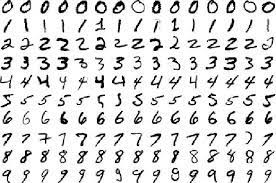

MNIST 데이터 셋은 28x28의 1채널 흑백 영상이고 원본 데이터는 각 픽셀별 0 ~ 255까지 8bit 정수형 변수를 갖는다. 이를 일반적으로 활용할 때에는 픽셀별 값을 아래와 같이 0 ~ 1사이로 표준화 하여 사용한다. 

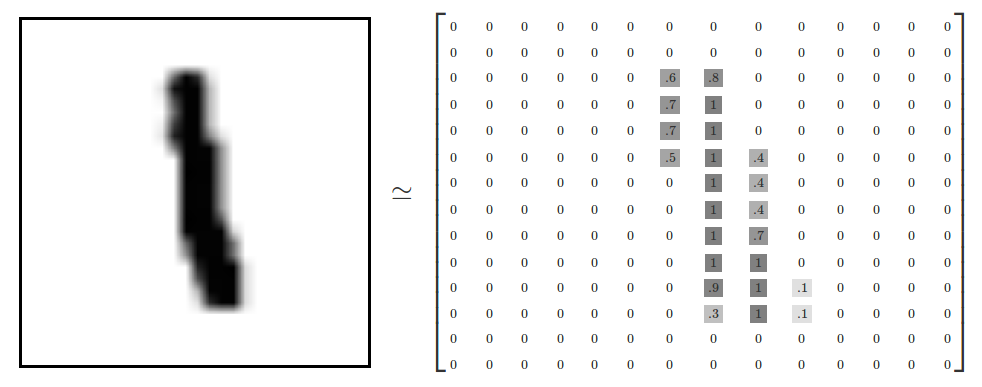

1. 아래와 같이 MNIST 데이터 셋을 TF 에서 다운로드 받으면 총 60000개의 학습용 데이터와 10000개의 검증용 데이터를 다운 받을 수 있다.

In [1]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

2. 위에서 다운받은 MNIST 데이터 셋중 학습용 데이터 셋을 이용하여 MNIST 데이터 셋을 분류할 수 있는 간단한 Covolutional Neural Network 분류기를 만들과, 검증용 데이터 셋으로 성능을 검증하시오.
 - 데이터 전처리 및 신경망의 모델은 사용자가 선택한 전략에 따라 구현하시오.

In [7]:
### MNIST Classifier with CNN 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist


plt.style.use("seaborn-white")
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.family"] = "monospace"
plt.rcParams["axes.unicode_minus"] = False

np.random.seed(42)
tf.random.set_seed(42)
np.set_printoptions(precision=3)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

# Scale images to [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# image shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]
print("input shape:", input_shape)
print("num_classes:", num_classes)

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)
print("y_train_onehot shape:", y_train_onehot.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
input shape: (28, 28, 1)
num_classes: 10
y_train_onehot shape: (60000, 10)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0   

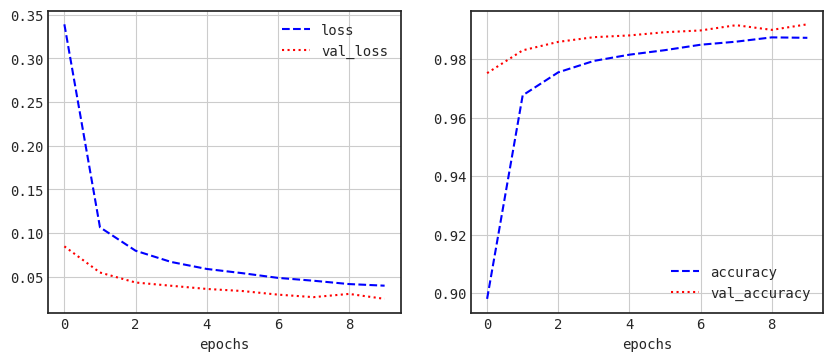

In [8]:
inputs = Input(shape=input_shape, dtype=tf.float64)
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
feature_extractor = Flatten()(x)
x = Dropout(0.5)(feature_extractor)
outputs = Dense(num_classes, activation="softmax")(x)

cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.summary()

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"]
)
callbacks = [EarlyStopping(monitor="val_accuracy", patience=2)]
history = cnn_model.fit(
    x_train,
    y_train_onehot,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test_onehot),
    callbacks=callbacks,
    verbose=0,
)

score = cnn_model.evaluate(x_test, y_test_onehot, verbose=1)
cnn_acc = score[1]
print(f"Test loss: {score[0]*100:.2f}%")
print(f"Test accuracy: {score[1]*100:.2f}%")

hist_items = ["loss", "accuracy"]
plt.figure(figsize=(10, 4))
for i, item in enumerate(hist_items):
    plt.subplot(1, 2, i + 1)
    plt.plot(history.history[item], "b--", label=item)
    plt.plot(history.history[f"val_{item}"], "r:", label=f"val_{item}")
    plt.xlabel("epochs")
    plt.grid()
    plt.legend()
plt.show()

predictions = cnn_model.predict(x_test)

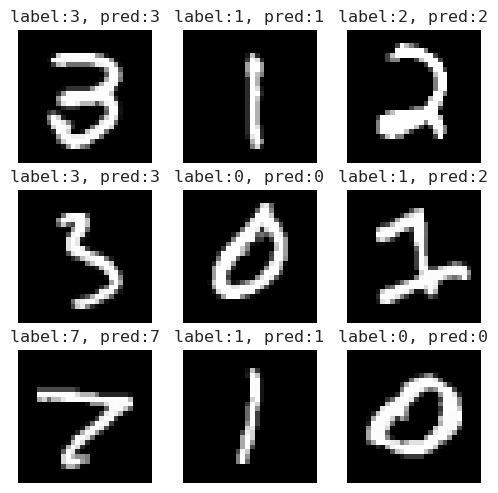

In [13]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_test.shape[0], size=9)
images = x_test[indexes]
labels = y_test[indexes]

plt.figure(figsize=(6, 6))
for i in range(len(indexes)):
    plt.subplot(3, 3, i + 1)
    image = images[i].reshape(28, 28)
    plt.imshow(image, cmap="gray")
    plt.title(f"label:{labels[i]}, pred:{np.argmax(predictions[indexes[i]])}")
    plt.axis("off")
plt.show()

3. 2번에서 구현한 MNIST 분류 CNN에서 Feature extraction 부분만을 이용하여, Feature extraction layer 뒤에 일반적인 Machine Learning 알고리즘(KNN, Decision Tree, SVM 및 다양한 Boosting 계열의 classifier)를 결합하여, MNIST DB를 구분하는 분류기를 구한한 뒤, Test data로 검증해보시오

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0   

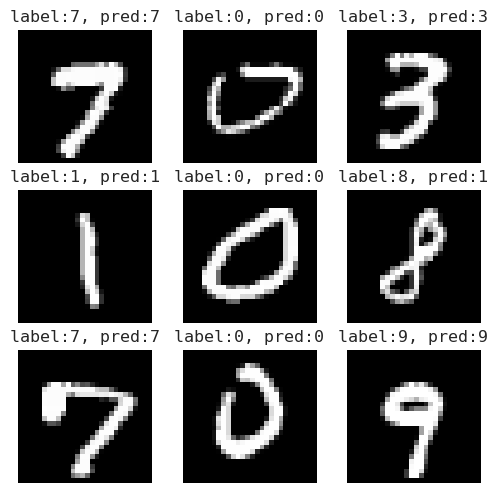

In [15]:
### MNIST Classifier with CNN Feature extractor + ML Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


feature_model = Model(inputs=inputs, outputs=feature_extractor)
feature_model.summary()

x_train_feature = feature_model.predict(x_train)
x_test_feature = feature_model.predict(x_test)
print(x_train_feature.shape)


rf_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=4, n_jobs=-1)
rf_clf.fit(x_train_feature, y_train)
y_pred_rf = rf_clf.predict(x_test_feature)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Test accuracy (RandomForest): {rf_acc*100:.2f}%")

indexes = np.random.randint(0, x_test.shape[0], size=9)
images = x_test[indexes]
labels = y_test[indexes]

plt.figure(figsize=(6, 6))
for i in range(len(indexes)):
    plt.subplot(3, 3, i + 1)
    image = images[i].reshape(28, 28)
    plt.imshow(image, cmap="gray")
    plt.title(f"label:{labels[i]}, pred:{y_pred_rf[indexes[i]]}")
    plt.axis("off")
plt.show()

In [17]:
def clf_pred_accuracy(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    return accuracy_score(y_test, y_pred)


clf_dict = {
    "RandomForest": RandomForestClassifier(n_estimators=500, max_leaf_nodes=8, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(max_leaf_nodes=16),
    "LinearSVM": LinearSVC(C=0.01, max_iter=100000),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1),
}

print(f"Test accuracy (CNN): {cnn_acc*100:.2f}%")
for name, clf in clf_dict.items():
    accuracy = clf_pred_accuracy(clf, x_train_feature, y_train, x_test_feature, y_test)
    print(f"Test accuracy ({name}): {accuracy*100:.2f}%")

Test accuracy (CNN): 99.19%
Test accuracy (RandomForest): 91.22%
Test accuracy (KNN): 98.82%
Test accuracy (DecisionTree): 80.07%
Test accuracy (LinearSVM): 99.39%
Test accuracy (AdaBoost): 95.73%
Test accuracy (XGBoost): 98.95%
